In [1]:
import numpy as np
import tensorflow as tf
import random
from collections import deque
import gym
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
tf.set_random_seed(0)
random.seed(0)

env = gym.make('CartPole-v0')
env.seed(0)

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

dis = 0.99
REPLAY_MEMORY = 10000
batch_size = 128
alpha = 0.6
beta_init = 0.4
eps = 0.01
training_step = 20
copy_step = 40

[2018-02-20 01:13:37,193] Making new env: CartPole-v0


In [3]:
class DQN :
    def __init__(self, session, input_size, output_size, name="main") :
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.net_name = name
        self._build_network()
        
    def _build_network(self, h_size=128, l_rate=0.005) :
        with tf.variable_scope(self.net_name):
            self._X = tf.placeholder(tf.float32, [None, self.input_size], name="input_x")
            
            W1 = tf.get_variable("W1", shape=[self.input_size, h_size],
                                 initializer=tf.contrib.layers.xavier_initializer(seed = 0))
            layer1 = tf.nn.relu(tf.matmul(self._X, W1))
            
            W2 = tf.get_variable("W2", shape=[h_size, h_size],
                                 initializer=tf.contrib.layers.xavier_initializer(seed = 0))
            W3 = tf.get_variable("W3", shape=[h_size, h_size],
                                 initializer=tf.contrib.layers.xavier_initializer(seed = 0))
            layer2 = tf.nn.relu(tf.matmul(layer1, W2))
            layer3 = tf.nn.relu(tf.matmul(layer1, W3))
            
            W_V = tf.get_variable("W_V", shape=[h_size, 1],
                                 initializer=tf.contrib.layers.xavier_initializer(seed = 0))
            
            W_A = tf.get_variable("W_A", shape=[h_size, self.output_size],
                                 initializer=tf.contrib.layers.xavier_initializer(seed = 0))
            
            self.Value = tf.matmul(layer2, W_V)
            self.Advantage = tf.matmul(layer3, W_A)
            
            self._Qpred = self.Value + self.Advantage - tf.reduce_mean(self.Advantage,
                                                                       reduction_indices=1,keep_dims=True)
        
        self._Y = tf.placeholder(shape=[None, self.output_size], dtype=tf.float32)
        
        self._WIS = tf.placeholder(shape=[1, 1], dtype=tf.float32)
        #self._WIS = tf.placeholder(shape=[1, self.output_size], dtype=tf.float32)
        
        self._loss = tf.reduce_mean(tf.square(self._Y - self._Qpred))
        #self._loss = tf.reduce_mean(tf.multiply(self._WIS, tf.square(self._Y - self._Qpred)))
        #self._loss = tf.reduce_mean(self._WIS * tf.square(self._Y - self._Qpred))
        
        self._train = tf.train.AdamOptimizer(learning_rate = l_rate).minimize(self._loss)
    
    def predict(self, state):
        x = np.reshape(state, [1,self.input_size])
        return self.session.run(self._Qpred, feed_dict={self._X : x})
    
    def update(self, x_stack, y_stack, w_stack):
        return self.session.run([self._loss, self._train],
                                feed_dict={self._X : x_stack, self._Y : y_stack, self._WIS : w_stack})

In [4]:
def sparsetau(x):
    x = np.array(x)
    sorted_x = np.sort(x)[::-1]
    S = np.array([])
    for i in range(0,len(x)):
        if 1+(i+1)*sorted_x[i] >= (sorted_x[0:(i+1)]).sum():
            S = np.append(S,sorted_x[i])
    tau = (S.sum() - 1)/S.size
    return tau, S

def sparsedist(x, scale = 1):
    x = np.array(x/scale)
    tau, _ = sparsetau(x)
    p = x - tau
    p[p<0] = 0
    if p.sum() > 0.0:
        p = p/p.sum()
    else:
        p = np.ones_like(x)/x.shape[0];
    return p

def sparsemax(x,scale = 1):
    x = np.array(x/scale)
    tau, S = sparsetau(x)
    spmax_x = 0.5*(S**2 - tau**2).sum() + 0.5
    spmax_x = scale*spmax_x
    return spmax_x

In [5]:
def replay_train (mainDQN, targetDQN, train_batch, w_batch) :
    x_stack = np.empty(0).reshape(0, input_size)
    y_stack = np.empty(0).reshape(0, output_size)
    w_stack = np.empty(0).reshape(0, 0)
    
    for state, action, reward, next_state, done in train_batch:
        Q = mainDQN.predict(state)
        
        if done :
            Q[0,action] = reward
        else :
            action_mat = targetDQN.predict(next_state)
            action_max = sparsemax(action_mat[0])
            Q[0,action] = reward + dis * action_max
    
        y_stack = np.vstack([y_stack, Q])
        x_stack = np.vstack([x_stack, state])
        
    for w in w_batch:
        w_stack = np.vstack([w])
        
    return mainDQN.update(x_stack, y_stack, w_stack)

In [6]:
def get_copy_var_ops(dest_scope_name="target", src_scope_name="main"):
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = src_scope_name)
    
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
    
    return op_holder

In [7]:
def bot_play(mainDQN) :
    s = env.reset()
    reward_sum = 0
    while True :
        env.render()
        a = np.argmax(mainDQN.predict(s))
        s,reward,done,_ = env.step(a)
        reward_sum += reward
        
        if done :
            print ("Total score : {}".format(reward_sum))
            break

In [8]:
def main():
    max_episodes = 500
    end_episode = 0
    step_count_total = 0
    global_step = 0
    beta = beta_init
    
    replay_buffer = deque()
    TD_error_list = []
    steps_list = []
    step_avg_list = []
    
    with tf.Session() as sess :
        mainDQN = DQN(sess, input_size, output_size, name="main")
        targetDQN = DQN(sess, input_size, output_size, name="target")
        
        tf.initialize_all_variables().run()
        copy_ops = get_copy_var_ops(dest_scope_name = "target",
                                                src_scope_name = "main")
        sess.run(copy_ops)
    
        for episode in range(1, max_episodes):
            done = False
            step_count = 0
            TD_error = 0
            state = env.reset()
            
            while not done:
                action_mat = mainDQN.predict(state)
                action_dist = sparsedist(action_mat[0])
                action = np.random.choice(len(action_dist),size=1,p=action_dist)
                
                next_state, reward, done, _ = env.step(action[0])
                step_count += 1
                global_step += 1
                
                if done:
                    if step_count < 200:
                        reward = -100
                    TD_error = reward
                else:
                    action_mat = targetDQN.predict(next_state)
                    action_max = sparsemax(action_mat[0])
                    TD_error = reward + dis * action_max
                
                TD_error -= np.max(mainDQN.predict(state))
                TD_error = pow((abs(TD_error) + eps), alpha)
                TD_error_list.append(TD_error)
                
                if beta < 1:
                    beta +=(1 - beta_init)/REPLAY_MEMORY
                
                replay_buffer.append((state, action, reward, next_state, done))
                if len(replay_buffer) > REPLAY_MEMORY:
                    replay_buffer.popleft()
                
                state = next_state
                
                if global_step > batch_size and global_step % training_step == 0:
                    TD_copy = []
                    TD_norm_list = []
                    TD_accum_list = []
                    W_is_list = []

                    start = 0
                    len_TD = len(TD_error_list)
                    if(len_TD > REPLAY_MEMORY):
                        start = len_TD - REPLAY_MEMORY
                        TD_copy = TD_error_list[start : len_TD]
                        len_TD = REPLAY_MEMORY
                    else:
                        TD_copy = TD_error_list[:]

                    sum_TD = sum(TD_copy)
                    TD_norm_list = [TD_copy[i] / sum_TD for i in range(len_TD)]
                    TD_accum_list = np.cumsum(TD_norm_list)

                    #W_is_list = [np.power((REPLAY_MEMORY * TD_norm_list[i]), -beta) for i in range(len_TD)]
                    #maxW = np.max(W_is_list)
                    #W_is_list = [W_is_list[i] / maxW for i in range(len_TD)]

                    W_is_list = np.ones([len(TD_accum_list)])

                    minibatch = []
                    w_batch = []

                    TDT = np.zeros([len(TD_accum_list)])
                    for i in range(batch_size):
                        check = True
                        while check:
                            rand_batch = random.random()
                            TD_index = np.nonzero(TD_accum_list >= rand_batch)[0][0]
                            if TDT[TD_index] == 0:
                                TDT[TD_index] = 1
                                check = False

                        w_batch.append(W_is_list[TD_index])
                        minibatch.append(replay_buffer[TD_index])

                    loss, _ = replay_train(mainDQN, targetDQN, minibatch, w_batch)

                if global_step % copy_step == 0:
                    sess.run(copy_ops)
                
            #print("episode: {}   steps: {}".format(episode, step_count))
            steps_list.append(step_count)
            
            if episode < 100:
                step_count_total += steps_list[episode - 1]
                step_avg_list.append(step_count_total / episode)
                
            if episode == 100:
                step_count_total += steps_list[episode - 1]
                step_avg_list.append(step_count_total / 100)
                #print ("Step Average 100:  ", step_avg_list[episode - 1])
                
            if episode > 100:
                step_count_total += steps_list[episode - 1]
                step_count_total -= steps_list[episode - 101]
                step_avg_list.append(step_count_total / 100)
                #print ("Step Average 100:  ", step_avg_list[episode - 1])
            
            print("{}           {}".format(episode, step_avg_list[episode - 1]))
            end_episode += 1
            if step_avg_list[episode - 1] > 195:
                break
        
        print("--------------------------------------------------")
        print("--------------------------------------------------")
        for episode in range(end_episode + 1, max_episodes):
            s = env.reset()
            reward_sum = 0
            while True :
                #env.render()
                a = np.argmax(mainDQN.predict(s))
                s,reward,done,_ = env.step(a)
                reward_sum += reward
        
                if done :
                    #print("episode: {}   steps: {}".format(episode, reward_sum))
                    steps_list.append(reward_sum)
                    step_count_total += steps_list[episode - 1]
                    step_count_total -= steps_list[episode - 101]
                    step_avg_list.append(step_count_total / 100)
                    print("{}           {}".format(episode, step_avg_list[episode - 1]))
                    break
        
        x_values = list(range(1, max_episodes))
        y_values = step_avg_list[:]
        plt.plot(x_values, y_values, c='green')
        plt.grid(True)
        plt.show()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2018-02-20 01:13:38,938] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/util/tf_should_use.py:107: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


1           11
2           12
3           14
4           15
5           15
6           14
7           15
8           15
9           17
10           18
11           21
12           26
13           28
14           30
15           33
16           35
17           37
18           37
19           39
20           41
21           41
22           48
23           48
24           50
25           52
26           52
27           51
28           51
29           51
30           54
31           54
32           58
33           61
34           65
35           69
36           72
37           76
38           79
39           82
40           85
41           88
42           90
43           93
44           95
45           98
46           100
47           102
48           104
49           106
50           108
51           110
52           111
53           113
54           115
55           116
56           118
57           119
58           121
59           122
60           123
61           124
62           126


417           196.24
418           196.24
419           196.24
420           196.24
421           196.24
422           194.35
423           194.35
424           194.35
425           194.35
426           194.35
427           194.35
428           194.35
429           196.23
430           196.23
431           196.23
432           196.23
433           196.23
434           196.23
435           196.23
436           196.23
437           196.23
438           196.23
439           196.23
440           196.23
441           196.23
442           196.23
443           196.23
444           196.23
445           196.23
446           196.23
447           196.23
448           196.23
449           196.23
450           196.23
451           196.23
452           196.23
453           196.23
454           196.23
455           196.23
456           196.23
457           196.23
458           196.23
459           196.23
460           196.23
461           196.23
462           196.23
463           194.35
464          

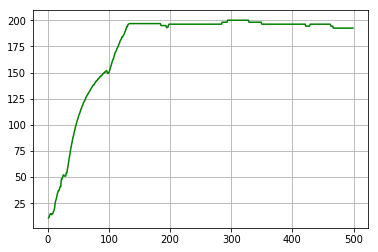

In [9]:
main()